In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms#, datasets
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

print("Done")

Done


In [2]:
# Dataset and Annotations
input_directory = "..\\o_npy_resized" #244x244 npy files
annotations_path = "height_annotations.csv"

In [3]:
# Seed
torch.manual_seed(627726)

In [4]:
# Dataset Class
class HeightDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[(self.annotations['Height'] != 0) & (self.annotations['Height'].notnull())] # removes rows where age is unknown
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = np.load(img_path)
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [5]:
# Create Dataset
dts = HeightDataset(csv_file=annotations_path, root_dir=input_directory, transform=transforms.ToTensor())

In [6]:
"""
# Get Min and Max
min_val = 1000.0
max_val = 0.0
avg_val = 0.0
total_val = 0.0
for i in dts:
    min_val = min(i[1].item(), min_val)
    max_val = max(i[1].item(), max_val)
    total_val += i[1].item()
avg_val = total_val/len(dts)
print(min_val)
print(max_val)
print(total_val)
print(avg_val)
"""

30.0
107.0
462863.0
68.38992316784869


In [21]:
# Create Test and Train Data
train_size = int(len(dts) * 0.8)
test_size = len(dts) - train_size

train_data, test_data = torch.utils.data.random_split(dts, [train_size, test_size])

In [28]:
# Model Class
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)

        self.dp1 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(26*26*128, 1)

    def forward(self, X):
        # Basically what we did in the previous step
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)

        # Flatten Data
        # input is -1 to automatically infer batch size, this means we can have a varying batch size
        # output is the number of features
        X = X.view(-1, 26*26*128)

        # Dropout
        X = self.dp1(X)
        
        # FC Layers
        X = self.fc1(X)

        return X #F.log_softmax(X, dim=1)

In [41]:
# Create Model
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dp1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=86528, out_features=1, bias=True)
)

In [42]:
# Loss Function optimizer
criterion = nn.L1Loss() # MAE Loss for outliers
# lr is learning rate, smaller is slower but better, higher is faster but worse
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
import time
start_time = time.time()

# Define Tracking Vars
# Number of times to train and test
epochs = 10
train_losses = []
test_losses = []

# Train and Test Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Loop of Epochs
for i in range(epochs):
    model.train()

    # Train
    running_train_loss = 0.0
    for b,(X_train, y_train) in enumerate(train_loader):
        b += 1 #start batches at 1
        
        y_pred = model(X_train).squeeze()  # get predicted values from training set. 2D not flat
        loss = criterion(y_pred, y_train) # How wrong is the prediction

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track Loss
        running_train_loss += loss.item()

        # Print Results
        if b%10 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()} Time: {time.time() - start_time}")

    train_losses.append(running_train_loss/len(train_loader))
    print(f"Epoch: {i} Avg Loss: {running_train_loss/len(train_loader)} Time: {time.time() - start_time}")

    # Test
    # No gradient
    # Don't update weight or biases
    running_test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test).squeeze()

            # Track Loss
            loss = criterion(y_val, y_test)
            running_test_loss += loss.item()

        #loss = criterion(y_val, y_test)
        test_losses.append(running_test_loss/len(test_loader))
        
current_time = time.time()
total = current_time - start_time

print(f"Training Took: {total} seconds!")

Epoch: 0 Batch: 10 Loss: 18.24191665649414 Time: 6.208438158035278
Epoch: 0 Batch: 20 Loss: 11.952093124389648 Time: 12.371129274368286
Epoch: 0 Batch: 30 Loss: 7.5282182693481445 Time: 18.50607991218567
Epoch: 0 Batch: 40 Loss: 6.2377471923828125 Time: 24.65708351135254
Epoch: 0 Batch: 50 Loss: 6.2650604248046875 Time: 30.734382390975952
Epoch: 0 Batch: 60 Loss: 5.7082600593566895 Time: 36.89595293998718
Epoch: 0 Batch: 70 Loss: 5.877298355102539 Time: 42.95984625816345
Epoch: 0 Batch: 80 Loss: 6.5117573738098145 Time: 49.12729787826538
Epoch: 0 Batch: 90 Loss: 6.626343727111816 Time: 55.30583739280701
Epoch: 0 Batch: 100 Loss: 5.569552421569824 Time: 61.44880509376526
Epoch: 0 Batch: 110 Loss: 5.951207160949707 Time: 67.56277799606323
Epoch: 0 Batch: 120 Loss: 5.464631080627441 Time: 73.6991879940033
Epoch: 0 Batch: 130 Loss: 6.67194128036499 Time: 79.80106711387634
Epoch: 0 Batch: 140 Loss: 8.240560531616211 Time: 85.93752479553223
Epoch: 0 Batch: 150 Loss: 5.294063568115234 Time: 9

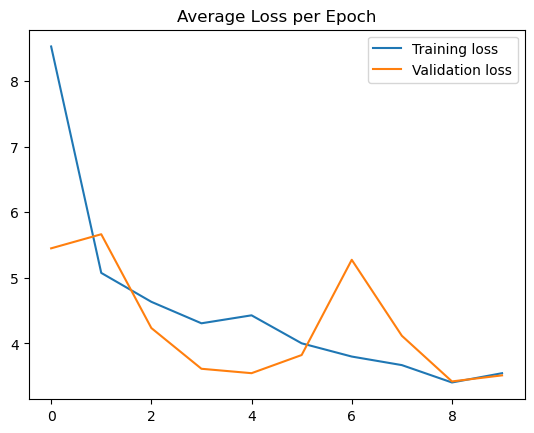

In [50]:
# Graphing
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Average Loss per Epoch")
plt.legend()
plt.savefig("height_estimation_finale.png")
plt.show()

In [47]:
# Save Loss Data
combined = np.column_stack((train_losses, test_losses))

# Save to CSV
np.savetxt("o_avg_loss.csv", combined, delimiter=",", header="Training Loss,Test Loss", comments='', fmt='%s')

In [ ]:
# Compute R2

In [33]:
# Grab an image
my_index = 303
test_data[my_index][1] # This is the label, ie it's classification
#test_data[my_index][0] # image in numpy format

tensor(67.)

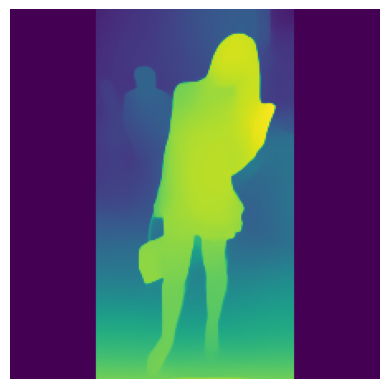

In [34]:
#Show image
plt.imshow(test_data[my_index][0].reshape(224,224))
plt.axis("off")
plt.show()

In [46]:
# Evaluate Grabbed Datapoint
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[my_index][0].view(1,1,224,224)) # Batch size of 1, 1 channel, 224x224

new_prediction.item()

66.59010314941406

In [49]:
# Save Model
torch.save(model.state_dict(), "epochs_finale_10.pt")